**多项式回归**

尝试拟合如下多项式： 
$$y = 5 + 1.2x - 3.4\frac{x^2}{2!} + 5.6 \frac{x^3}{3!} + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.1^2).$$

In [1]:
import numpy as np

g_max_degree = 20
g_num_train, g_num_test = 100, 100
true_w = np.zeros(g_max_degree)
true_w[0:4] = np.array([5, 1.2, -3.4, 5.6])

In [4]:
import math

features = np.random.normal(size=(g_num_train + g_num_test, 1))
np.random.shuffle(features) # features 是自变量 x

poly_features = np.power(features, np.arange(g_max_degree).reshape(1, -1)) # 做对于x的指数
for i in range(g_max_degree):
    poly_features[:, i] /= math.gamma(i + 1) # 除以一个阶乘，避免数值爆炸
labels = np.dot(poly_features, true_w) # 乘上参数 w
labels += np.random.normal(scale=0.1, size=labels.shape)

In [7]:
import torch
true_w, features, poly_features, labels = [torch.tensor(x, dtype=
    torch.float32) for x in [true_w, features, poly_features, labels]]

features[:2], poly_features[:2, :], labels[:2]

(tensor([[-1.3624],
         [-0.7638]]),
 tensor([[ 1.0000e+00, -1.3624e+00,  9.2809e-01, -4.2148e-01,  1.4356e-01,
          -3.9117e-02,  8.8824e-03, -1.7288e-03,  2.9442e-04, -4.4569e-05,
           6.0721e-06, -7.5207e-07,  8.5386e-08, -8.9485e-09,  8.7083e-10,
          -7.9096e-11,  6.7351e-12, -5.3976e-13,  4.0855e-14, -2.9295e-15],
         [ 1.0000e+00, -7.6380e-01,  2.9169e-01, -7.4265e-02,  1.4181e-02,
          -2.1663e-03,  2.7576e-04, -3.0090e-05,  2.8728e-06, -2.4381e-07,
           1.8622e-08, -1.2930e-09,  8.2301e-11, -4.8355e-12,  2.6381e-13,
          -1.3433e-14,  6.4126e-16, -2.8811e-17,  1.2226e-18, -4.9147e-20]]),
 tensor([-2.3514,  2.7832]))

In [2]:
import sys
import os

sys.path.append(os.path.abspath(os.path.join('..')))

In [5]:
from utils.accumulator import Accumulator

def evaluate_loss(model, data_iter, loss):
    metric = Accumulator(2) # [0] 损失总和 [1] 样本数量
    for X, y in data_iter:
        predict = model(X)
        y = y.reshape(predict.shape)
        l = loss(predict, y)
        metric.add(l.sum(), l.numel())
    return metric[0] / metric[1]

In [ ]:
import d2l
import torch.nn as nn

def train(train_features, train_labels,
          test_features, test_labels, epochs = 400):
    loss = nn.MSELoss()
    input_shape = train_features.shape[-1]

    model = nn.Sequential(nn.Linear(input_shape, 1, bias=False))
    batch_size = min(10, train_labels.shape[0])

    train_iter = d2l.load_array((train_features, train_labels.reshape(-1, 1), batch_size))
    test_iter = d2l.load_array((test_features, test_labels.reshape(-1, 1), batch_size))

    trainer = torch.optim.SGD(model.parameters, lr = .01)
    

**权重衰减**

In [7]:
import torch
from torch import nn
from d2l import torch as d2l

尝试拟合函数：

$$y = 0.05 + \sum_{i = 1}^d 0.01 x_i + \epsilon \text{ where }
\epsilon \sim \mathcal{N}(0, 0.01^2).$$

In [9]:
n_train, n_test, num_inputs, batch_size = 20, 100, 200, 5
true_w, true_b = torch.ones((num_inputs, 1)) * .01, .05

In [14]:
train_data = d2l.synthetic_data(true_w, true_b, n_train) # 生成 y = XW + b
train_iter = d2l.load_array(train_data, batch_size)
test_data = d2l.synthetic_data(true_w, true_b, n_test)
test_iter = d2l.load_array(test_data, batch_size, is_train=False)

In [23]:
import torch

def init_params():
    w = torch.normal(0, 1, size=(num_inputs, 1), requires_grad=True)
    b = torch.zeros(1, requires_grad = True)

    return [w, b]

L2正则化：

$$ J_{\text{regularized}}(W) = L_{\text{original}}(W) + \frac{\lambda}{2m} \sum_{i=1}^{n} W_i^2 $$

要给 $W$ 一个平方项，这样 $W$ 变大就会得到很大的惩罚，因此会更多的分配权重。

In [19]:
def l2_penalty(w):
    return torch.sum(w.pow(2)) / 2

In [38]:
train_loss = []
test_loss = []
epochs = []

def train(coff):
    w, b = init_params()
    model, loss = lambda X : d2l.linreg(X, w, b), d2l.squared_loss
    num_epochs, lr = 100, .03
    
    for epoch in range(num_epochs):
        for X, y in train_iter:
            l = loss(model(X), y) + coff * l2_penalty(w)
            l.sum().backward()
            d2l.sgd([w, b], lr, batch_size)
        if (epoch + 1) % 5 == 0:
            epochs.append(epoch + 1)
            train_loss.append(d2l.evaluate_loss(model, train_iter, loss))
            test_loss.append(d2l.evaluate_loss(model, test_iter, loss))

In [39]:
train(3)

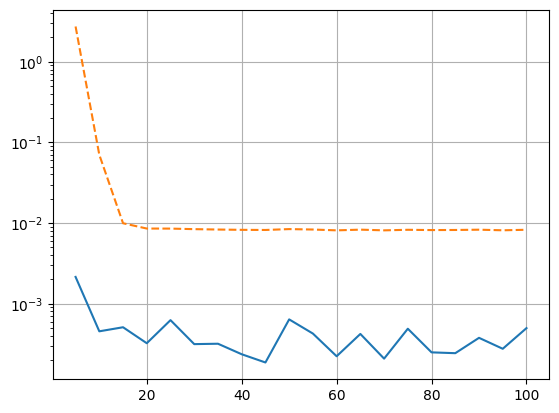

In [40]:
import matplotlib.pyplot as plt

plt.plot(epochs, train_loss, label="train loss")
plt.plot(epochs, test_loss, label="test loss", linestyle='--')
plt.grid(True)
plt.yscale('log')
plt.show()

In [36]:
train_loss

[0.02157452702522278,
 2.696061792448745e-05,
 2.4953855870535335e-08,
 3.2382095616068084e-11,
 7.443866703593649e-13,
 2.186655370661761e-13,
 1.410054364936464e-13,
 1.7655755329970546e-13,
 2.3159963530305917e-13,
 1.608173663680823e-13,
 3.01829568283285e-13,
 2.4155556027638523e-13,
 4.454674476517262e-13,
 2.6107050549173393e-13,
 3.8441350797002725e-13,
 3.810439810902899e-13,
 2.0809898942930615e-13,
 3.367960424438543e-13,
 2.770799215068287e-13,
 4.0255177663484074e-13]

**使用 torch api 的实现**

In [ ]:
def train_concise(wd):
    model = nn.Sequential(nn.Linear(num_inputs, 1))
    for param in model.parameters():
        param.data.normal_()

    loss = nn.MSELoss(reduction="none")
    num_epochs, lr = 100, .003

    trainer = torch.optim.SGD([
        { "params":model[0].weight, "weight_decay" : wd },
        { "params":model[0].bias }
    ], lr)

    for epoch in range(num_epochs):
        for X, y in train_iter:
            trainer.zero_grad()
            l = loss(model(X), y)
            l.mean().backward()
            trainer.step()

**暂退法**

随机干掉一部分神经元，强迫剩下的神经元高质量发展自立自强

In [2]:
# 暂退操作：以 proba 的概率干掉神经元，随后放缩保证期望不变

def dropout_layer(X, proba):
    if proba == 1:
        return torch.zeros_like(X)
    elif proba == 0:
        return X
    
    mask = (torch.rand(X.shape) > proba).float()
    return mask * X / (1.0 - proba)

In [8]:
import torch.nn as nn

dropout_1, dropout_2 = .2, .5
num_inputs, num_outputs, num_hiddens1, num_hiddens2 = 784, 10, 256, 256

            # 这他妈不会是继承吧
class Model(nn.Module):
    def __init__(self, num_inputs, num_outputs,
                 num_hidden1, num_hidden2, is_training = True) -> None:
        super(Model, self).__init__()
        self.num_inputs = num_inputs
        self.num_outputs = num_outputs

        self.lin1 = nn.Linear(num_inputs, num_hidden1)
        self.lin2 = nn.Linear(num_hidden1, num_hidden2)
        self.lin3 = nn.Linear(num_hidden2, num_outputs)
        self.relu = nn.ReLU()
    
    def forward(self, X):
        hd_layer1 = self.relu(self.lin1(X.reshape((-1, self.num_inputs))))
        if self.training == True:
            hd_layer1 = dropout_layer(hd_layer1, dropout_1)

        hd_layer2 = self.relu(self.lin2(hd_layer1))
        if self.training == True:
            hd_layer2 = dropout_layer(hd_layer2, dropout_2)
        
        out = self.lin3(hd_layer2)
        return out

model = Model(num_inputs, num_outputs, num_hiddens1, num_hiddens2)

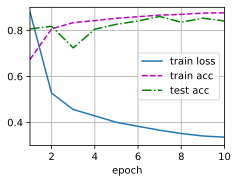

In [12]:
from d2l import torch as d2l

num_epochs, lr, batch_size = 10, 0.5, 256
loss = nn.CrossEntropyLoss(reduction='none')
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size)
trainer = torch.optim.SGD(model.parameters(), lr=lr)
d2l.train_ch3(model, train_iter, test_iter, loss, num_epochs, trainer)